### Lectura de la imagen e inicializacion de variables

8392704


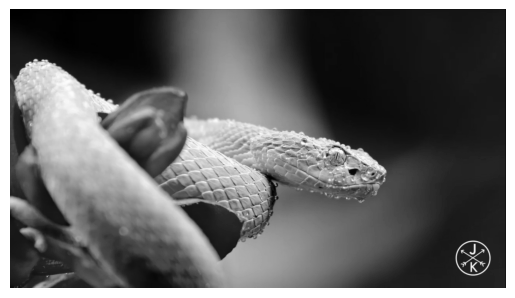

In [23]:
#Lectura de la imagen e inicializacion de variables
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import signal
from skimage.color import rgb2gray


qpsk = np.array([1+1j, -1+1j, 1-1j, -1-1j]) / np.sqrt(2)

qam16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j,  
                          -1-3j, -1-1j, -1+3j, -1+1j,  
                           3-3j,  3-1j,  3+3j,  3+1j,  
                           1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)

qam64 = np.array([-7-7j, -7-5j, -7-3j, -7-1j, -7+7j, -7+5j, -7+3.j, -7+1j,
                          -5-7j, -5-5j, -5-3j, -5-1j, -5+7j, -5+5j, -5+3j, -5+1j,
                          -3-7j, -3-5j, -3-3j, -3-1j, -3+7j, -3+5j, -3+3j, -3+1j,
                          -1-7j, -1-5j, -1-3j, -1-1j, -1+7j, -1+5j, -1+3j, -1+1j,
                           7-7j,  7-5j,  7-3j,  7-1j,  7+7j,  7+5j,  7+3j,  7+1j,
                           5-7j,  5-5j,  5-3j,  5-1j,  5+7j,  5+5j,  5+3j,  5+1j,
                           3-7j,  3-5j,  3-3j,  3-1j,  3+7j,  3+5j,  3+3j,  3+1j,
                           1-7j,  1-5j,  1-3j,  1-1j,  1+7j,  1+5j,  1+3j,  1+1j]) / np.sqrt(42)

#Parámetros 
Modulacion = '16-QAM' #Modulacion
BW = 10 #Ancho de banda en MHz
Referencia = 4+4j
matriz = np.array([[Referencia, -Referencia.conjugate()], [Referencia, Referencia.conjugate()]])
#matriz = np.array([[Referencia, Referencia], [Referencia.conjugate(), -Referencia.conjugate()]])
inversa = np.linalg.inv(matriz)
# Leer la imagen
imagena = mpimg.imread("Frame1.jpg")
imagen = rgb2gray(imagena)*255
datos_array = np.array(imagen, dtype=np.uint8)
datos = np.unpackbits(datos_array.flatten())
# Mostrar el número total de bits
# Mostrar la imagen original
print(len(datos))
plt.imshow(datos_array,cmap='gray')
plt.axis('off')
plt.show()

### Modulacion QPSK, 16-QAM, 64-QAM

In [24]:
#Modulacion QPSK, 16-QAM, 64-QAM
def generarSimbolos(datos, modulacion):
    longitud = len(datos)
    
    if modulacion == 'QPSK':
        # 2 bits por símbolo
        datos = np.array(datos).reshape(-1, 2)
        indices = datos.dot(1 << np.arange(2)[::-1])  # Mapea los bits a índices
        simbolos = qpsk[indices]

    elif modulacion == '16-QAM':
        # 4 bits por símbolo
        datos = np.array(datos).reshape(-1, 4)
        indices = datos.dot(1 << np.arange(4)[::-1])  # Mapea los bits a índices
        simbolos = qam16[indices]

    elif modulacion == '64-QAM':
        # 6 bits por símbolo
        datos = np.array(datos).reshape(-1, 6)
        indices = datos.dot(1 << np.arange(6)[::-1])  # Mapea los bits a índices
        simbolos = qam64[indices]

    else: 
        raise Exception('Solo de QPSK a 64QAM.')
    
    return simbolos

nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = generarSimbolos(datos,Modulacion)
prueba2=modulado.copy()
print(len(modulado))
for i in range(6,nSubportadoras,12):
    modulado = np.insert(modulado, i, Referencia)
    modulado = np.insert(modulado, i+1, Referencia)


nSimbolos = len(modulado)
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)
print('Número de bloques de recursos:',nBloques)
print('Número de subportadoras:',nSubportadoras)
print('Número de símbolos a enviar:',nSimbolos)
print('Número de símbolos OFDM:',nSimbolosOFDM)

#print(modulado[0:12*3])

2098176
Número de bloques de recursos: 56
Número de subportadoras: 672
Número de símbolos a enviar: 2098288
Número de símbolos OFDM: 3123


### Modulacion OFDM

In [25]:
#Modulacion OFDM
N = 2**math.ceil(math.log2(nSubportadoras))
print(N)


datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
datosOFDM2 = np.zeros(nSimbolosOFDM * N, np.complex64)
modulado2 = np.zeros(len(modulado), np.complex64)
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM

for i in range(len(modulado)):
    if i%2 == 0:
        modulado2[i] = -modulado[i+1].conjugate()
    else:
        modulado2[i] = modulado[i-1].conjugate()

for i in range(nSimbolosOFDM):
    scArray = np.zeros(N, np.complex64)
    scArray2 = np.zeros(N, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(modulado[j:j+nSubportadoras])
        if longitud < nSubportadoras:
            scArray[0:nSubportadoras] = np.concatenate((modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
            scArray2[0:nSubportadoras] = np.concatenate((modulado2[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
        else:
            scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
            scArray2[0:nSubportadoras] = modulado2[j:j+nSubportadoras]
    else:
        scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
        scArray2[0:nSubportadoras] = modulado2[j:j+nSubportadoras]
    # Realizar la modulación IFFT
    datosOFDMsr = np.fft.ifft(np.fft.fftshift(scArray), N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
    datosOFDMsr2 = np.fft.ifft(np.fft.fftshift(scArray2), N)
    datosOFDM[k:k + N] = datosOFDMsr
    datosOFDM2[k:k + N] = datosOFDMsr2
    # Incrementar los índices
    j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
    k = k + N  # Incrementar el índice para los datos OFDM




1024


### Prefijo ciclico

In [26]:
# Define la función para agregar el prefijo cíclico (CP)
def anadirPrefijo(simboloOfdm, N, longitudCP):
    # Extraer el CP (las últimas longitudCP muestras del símbolo OFDM)
    cp = simboloOfdm[N - longitudCP:N:1]
    
    # Concatenar el CP y el símbolo OFDM
    simboloOfdm_cp = np.concatenate((cp, simboloOfdm))
    
    return simboloOfdm_cp

longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
ofdmConCP2 = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)
j = 0
k = 0
for i in range(nSimbolosOFDM):
    # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
    ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[j:j + N], N, longitudCP)
    ofdmConCP2[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM2[j:j + N], N, longitudCP)
    # Incrementar los índices para la siguiente iteración
    j = j + N
    k = k + N + longitudCP

### Efectos del canal

In [27]:
#Efectos del canal
# Parámetros del canal de multicamino
nCaminos = 5
h = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
canal = np.fft.fftshift(np.fft.fft(h,N))
Senal_mp = np.convolve(ofdmConCP,h)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]
nCaminos = 5
h2 = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
canal2 = np.fft.fftshift(np.fft.fft(h2,N))
Senal_mp2 = np.convolve(ofdmConCP2,h2)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]
#Efecto de canal AWGN
SNR = 25 # Desired SNR (dB) 
def awgn(senal,SNR):
    # Measure signal power 
    potenciaSenal = np.mean(abs(senal)**2)

    # Calculate noise power 
    potenciaRuido = potenciaSenal/(10 **(SNR/10))
    
    # Generate complex noise 
    noise = np.sqrt(potenciaRuido/2)*(np.random.randn(len(senal)) + np.random.randn(len(senal))*1j)
    
    # Add signal and noise 
    senalRuidosa = senal + noise 
    
    return senalRuidosa 
SenalRx1 = awgn(Senal_mp,SNR)
SenalRx2 = awgn(Senal_mp2,SNR)
SenalRx = (SenalRx1+SenalRx2)
len(SenalRx)

3425931

### Demodulacion OFDM

2098176


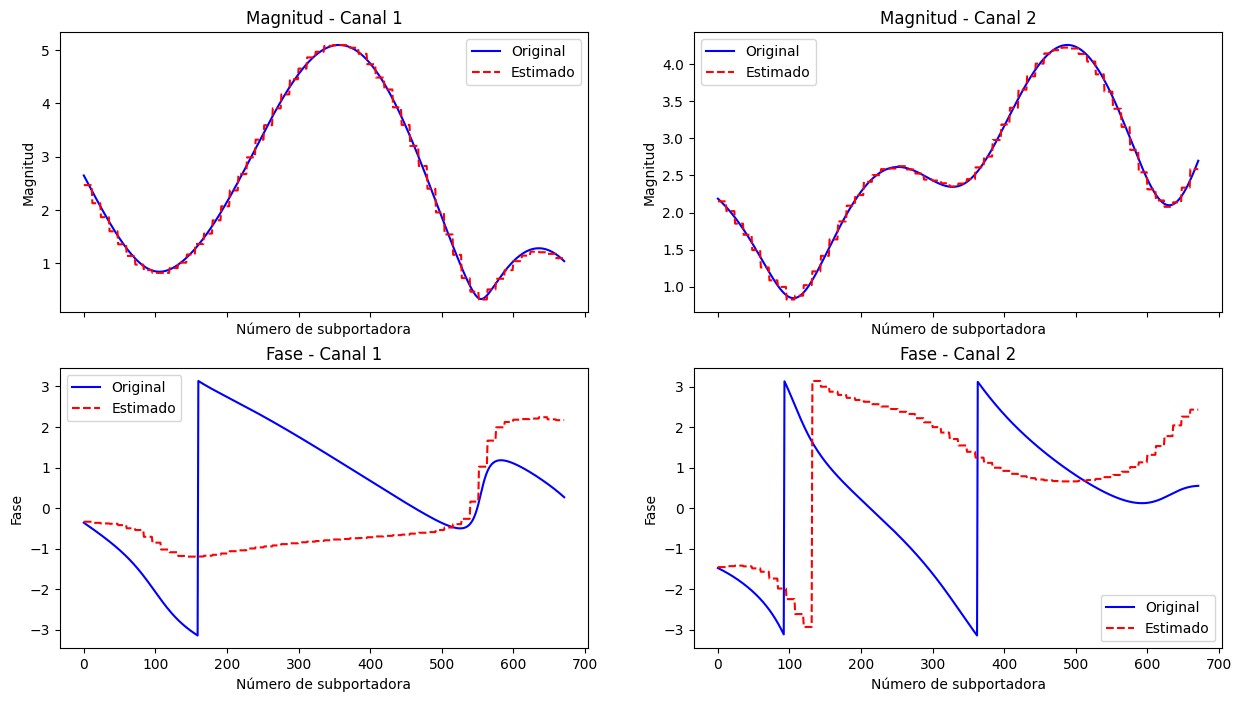

In [28]:
#Demodulacion OFDM
def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fftshift(np.fft.fft(ofdmSinPrefijo, N))
    return data

# Array para almacenar los símbolos de datos recuperados
rxDatos = np.zeros(nSimbolos-(2*nBloques), np.complex64)
RxDatos = np.zeros(nSimbolos-(2*nBloques), np.complex64)
estimado1 = []
estimado2 = []
j = 0
k = 0 
x = 0
# Extraer el contenido de datos (después del final del L-LTF)
L = len(SenalRx)
print(len(rxDatos))
Referencias_rx = []
Referencias_rx2 = []
estimado_rx1= []
estimado_rx2 = []
# Demodular los símbolos OFDM en el contenido de datos
for i in range(nSimbolosOFDM):
    rx_demod = demodulacionOFDM(SenalRx[k:(k + N + longitudCP)], N, longitudCP)
    if i == 0:
        prueba = rx_demod.copy()
        for l in range(len(rx_demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(rx_demod[l])
                x += 1
            elif l%12 == 7:
                if l <=nSubportadoras:
                    Referencias_rx2.append(rx_demod[l])
                x += 1
            else:
                RxDatos[l-x] = rx_demod[l]
        j = j + nSubportadoras - (2*nBloques)
        for l in range(len(Referencias_rx)):
            estimado_rx1.append((inversa[0,0]*Referencias_rx[l])+(inversa[0,1]*Referencias_rx2[l]))
            estimado_rx2.append((inversa[1,0]*Referencias_rx[l])+(inversa[1,1]*Referencias_rx2[l]))
        for l in range(nSubportadoras):
            estimado1.append(estimado_rx1[l//12])
            estimado2.append(estimado_rx2[l//12])
        Simbolo = RxDatos[0:(l-x)]
        #Simbolo2=RxDatos[0:(l-x)]
        for m in range(len(Simbolo)-1):
            if m%2 == 0:
                #print(j+m)
                rxDatos[m] = ((estimado1[m].conjugate() * Simbolo[m]) + (estimado2[m].conjugate() * Simbolo[m+1].conjugate())) / ((abs(estimado1[m])**2) + (abs(estimado2[m])**2))
                rxDatos[m+1] = ((estimado2[m].conjugate() * Simbolo[m]) - (estimado1[m] * Simbolo[m+1].conjugate())) / ((abs(estimado1[m])**2) + (abs(estimado2[m])**2))
                rxDatos[m+1] = -rxDatos[m+1].real +1j*rxDatos[m+1].imag

                    
    else:
        if i == (nSimbolosOFDM-1):
            #print(i)
            for m in range(len(rxDatos)-j):
                if m%2 == 0:
                    rxDatos[j+m] = ((estimado1[m].conjugate()*Simbolo[m])+(estimado2[m+1]*Simbolo[m+1].conjugate()))/((abs(estimado1[m])**2)+(abs(estimado2[m+1])**2))
                    rxDatos[j+m+1] = ((estimado2[m].conjugate()*Simbolo[m])-(estimado1[m+16]*Simbolo[m+1].conjugate()))/((abs(estimado1[m])**2)+(abs(estimado2[m+1])**2))
                    rxDatos[j+m+1] = -rxDatos[j+m+1].real +1j*rxDatos[j+m+1].imag
                    #rxDatos[j+m] = ((Simbolo[m])+(Simbolo[m+1].conjugate()))/2
                    #rxDatos[j+m+1] = ((Simbolo[m])-(Simbolo[m+1].conjugate()))/2
            #rxDatos[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos)-j)]
        else:
            #print("i",i)
            Simbolo = rx_demod[0:nSubportadoras]
            for m in range(nSubportadoras):
                if m%2 == 0:
                    #print("m",m)
                    #print(j+m)
                    rxDatos[j+m] = ((estimado1[m].conjugate()*Simbolo[m])+(estimado2[m+1]*Simbolo[m+1].conjugate()))/((abs(estimado1[m])**2)+(abs(estimado2[m+1])**2))
                    rxDatos[j+m+1] = ((estimado2[m].conjugate()*Simbolo[m])-(estimado1[m+1]*Simbolo[m+1].conjugate()))/((abs(estimado1[m])**2)+(abs(estimado2[m+1])**2))
                    rxDatos[j+m+1] = -rxDatos[j+m+1].real +1j*rxDatos[j+m+1].imag
                    #rxDatos[j+m] = ((Simbolo[m])+(Simbolo[m+1].conjugate()))/2
                    #rxDatos[j+m+1] = ((Simbolo[m])-(Simbolo[m+1].conjugate()))/2
            #rxDatos[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]
    
    # Actualizar los índices para la siguiente iteración
        j = j + nSubportadoras
    k = k + N + longitudCP


fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
axs[0, 0].plot(abs(canal)[0:nSubportadoras], 'b', label='Original')
axs[0, 0].plot(abs(np.array(estimado1))[0:nSubportadoras], '--r', label='Estimado')
axs[0, 0].set_title('Magnitud - Canal 1')
axs[0, 0].set_xlabel('Número de subportadora')
axs[0, 0].set_ylabel('Magnitud')
axs[0, 0].legend()

axs[1, 0].plot(np.angle(canal)[0:nSubportadoras], 'b', label='Original')
axs[1, 0].plot(np.angle(np.array(estimado1))[0:nSubportadoras], '--r', label='Estimado')
axs[1, 0].set_title(f'Fase - Canal 1')
axs[1, 0].set_xlabel('Número de subportadora')
axs[1, 0].set_ylabel('Fase')
axs[1, 0].legend()


axs[0, 1].plot(abs(canal2)[0:nSubportadoras], 'b', label='Original')
axs[0, 1].plot(abs(np.array(estimado2))[0:nSubportadoras], '--r', label='Estimado')
axs[0, 1].set_title('Magnitud - Canal 2')
axs[0, 1].set_xlabel('Número de subportadora')
axs[0, 1].set_ylabel('Magnitud')
axs[0, 1].legend()

axs[1, 1].plot(np.angle(canal2)[0:nSubportadoras], 'b', label='Original')
axs[1, 1].plot(np.angle(np.array(estimado2))[0:nSubportadoras], '--r', label='Estimado')
axs[1, 1].set_title(f'Fase - Canal 2')
axs[1, 1].set_xlabel('Número de subportadora')
axs[1, 1].set_ylabel('Fase')
axs[1, 1].legend()



### Demodulacion QPSK, 16-QAM, 64-QAM

In [29]:
#Demodulacion QPSK, 16-QAM, 64-QAM

constelaciones = {
    'QPSK': qpsk,
    '16-QAM': qam16,
    '64-QAM': qam64
}


def decision_vectorizada(modulado, matriz):
    # Calcular todas las distancias en una sola operación vectorizada
    distancias = np.abs(modulado[:, np.newaxis] - matriz)  # Broadcasting para calcular distancias
    indices = np.argmin(distancias, axis=1)  # Encuentra los índices de las distancias mínimas
    # Convertir los índices a binario de forma vectorizada
    bits = np.array([list(np.binary_repr(i, width=int(np.log2(len(matriz))))) for i in indices], dtype=int)
    return bits.flatten()  # Devolver como un solo vector plano

if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM, or 64-QAM.')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

# Aplicar la función de decisión a todos los valores modulados de una vez
dataSombrero = decision_vectorizada(rxDatos, constelacion)
print(len(rxDatos))

2098176


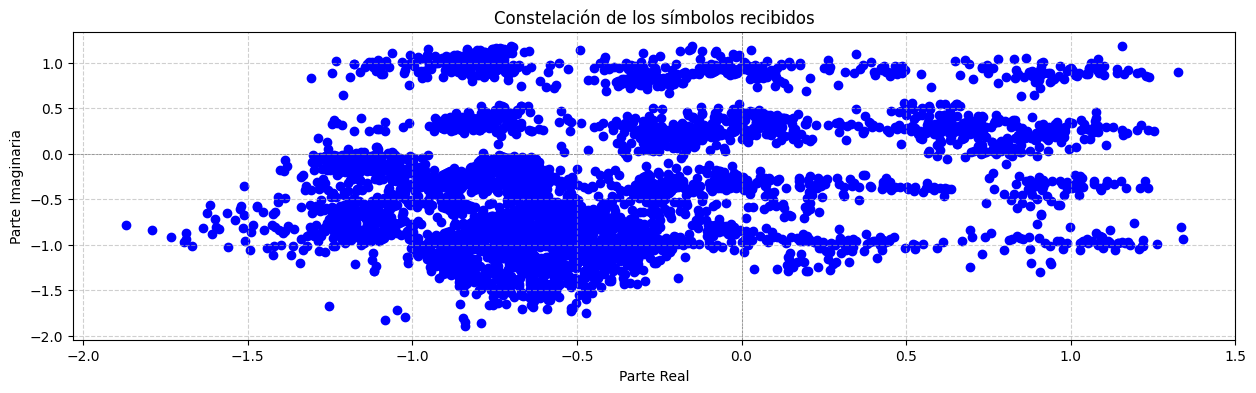

In [30]:
grafica = rxDatos[5000:10000]

plt.figure(figsize=(15, 4))  # Cuadrar para que sea proporcional
plt.scatter(grafica.real, grafica.imag, color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Constelación de los símbolos recibidos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [31]:
rxDatos = np.zeros(nSimbolos-(2*nBloques), np.complex64)
estimado_rx = []
j = 0
k = 0 
x = 0
# Extraer el contenido de datos (después del final del L-LTF)
L = len(SenalRx1)
print(len(rxDatos))
Referencias_rx = []
# Demodular los símbolos OFDM en el contenido de datos
for i in range(nSimbolosOFDM):
    rx_demod = demodulacionOFDM(SenalRx1[k:(k + N + longitudCP)], N, longitudCP)
    if i == 0:
        for l in range(len(rx_demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(rx_demod[l])
                x += 1
            elif l%12 == 7:
                x += 1
            else:
                rxDatos[l-x]=rx_demod[l]
        print(len(rx_demod))
        j = j + nSubportadoras - (2*nBloques)
        for l in range(nSubportadoras):
            estimado_rx.append(Referencias_rx[l//12])
        estimacion_canal = np.array(estimado_rx)/(Referencia)
    else:
        if i == (nSimbolosOFDM-1):
            rxDatos[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos)-j)]/estimacion_canal[0:(len(rxDatos)-j)]
        else:
            rxDatos[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]/estimacion_canal
    
    # Actualizar los índices para la siguiente iteración
        j = j + nSubportadoras
    k = k + N + longitudCP

dataSombrero2 = decision_vectorizada(rxDatos, constelacion)

2098176
1024


### Calculo del BER

In [32]:
def calcular_BER(bits_reales, bits_recibidos):
    if len(bits_reales) != len(bits_recibidos):
        raise ValueError("Los vectores deben tener la misma longitud.")
    
    # Calcular el número de bits en error
    errores = np.sum(bits_reales != bits_recibidos)
    
    # Calcular la Tasa de Error de Bit (BER)
    ber = errores / len(bits_reales)
    return ber
print(len(datos))
print(len(dataSombrero))
print("BER con SFBC:",calcular_BER(datos,dataSombrero))
print("BER sin SBFC:",calcular_BER(datos,dataSombrero2))


8392704
8392704
BER con SFBC: 0.031545613904648606
BER sin SBFC: 0.06552727225933382


### Grafica recibida

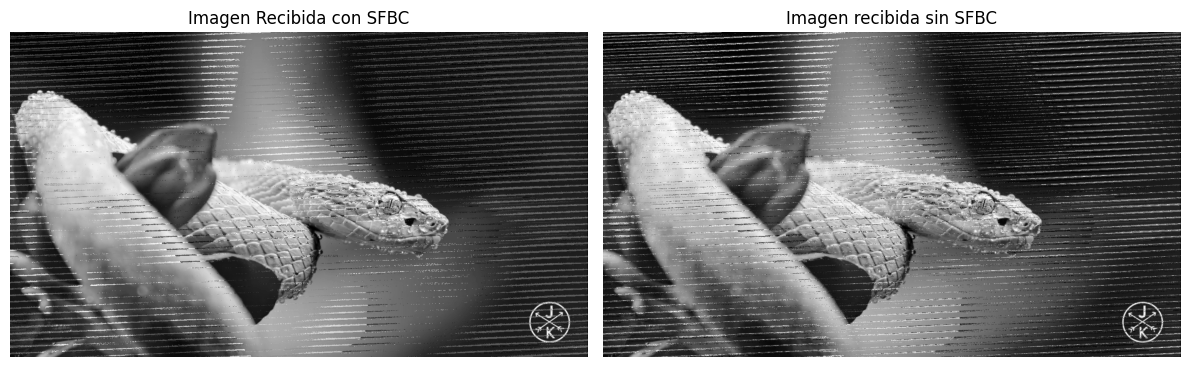

In [33]:
#Grafica recibida
datos_rx = dataSombrero
datos_rx2 = dataSombrero2

bits_array = np.array(datos_rx, dtype=np.uint8)
num_bytes = bits_array.size // 8  # Cantidad de bytes necesarios
bytes_array = bits_array[:num_bytes * 8].reshape(-1, 8)

bits_array2 = np.array(datos_rx2, dtype=np.uint8)
num_bytes2 = bits_array2.size // 8  # Cantidad de bytes necesarios
bytes_array2 = bits_array2[:num_bytes2 * 8].reshape(-1, 8)

# Convertir los grupos de 8 bits en valores enteros de 0 a 255 (uint8)
pixels_array = np.packbits(bytes_array)
pixels_array2 = np.packbits(bytes_array2)

# Reconstruir la imagen a partir de los píxeles
# Primero, debemos saber la forma original de la imagen
dimension_original = (768, 1366)  # Asegúrate de usar las dimensiones correctas
imagen_recuperada = pixels_array.reshape(dimension_original)
imagen_recuperada2 = pixels_array2.reshape(dimension_original)

# Mostrar la imagen recuperada
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
axes[0].imshow(imagen_recuperada, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Imagen Recibida con SFBC')

# Gráfica 2
axes[1].imshow(imagen_recuperada2, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Imagen recibida sin SFBC')

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()
